In [25]:
import numpy as np
# Data set
# Query(X): ‘0+0 ’, ‘0-0 ’, ‘0+1 ’, ‘0-1 ’, ..., ‘99+99’, ‘99-99’
# Answer(Y): ‘+0  ’, ‘+0 ’ , ‘+1  ’, ‘-1  ’ ..., ‘+198’, ‘+0 ’
def CreateData():
    query = []
    answer = []
    reverse_query = []
    reverse_answer = []
    for i in range(100):
        for j in range(100):
            query.append((f'{i}+{j}').ljust(5))
            reverse_query.append(((f'{i}+{j}').ljust(5))[::-1])
            query.append((f'{i}-{j}').ljust(5))
            reverse_query.append(((f'{i}-{j}').ljust(5))[::-1])
            answer.append((f'+{i+j}').ljust(4))
            reverse_answer.append(((f'+{i+j}').ljust(4))[::-1])
            answer.append((f'{i-j:+d}').ljust(4))
            reverse_answer.append(((f'{i-j:+d}').ljust(4))[::-1])
    
    print(query[1301])
    print(reverse_query[1301])
    print(answer[1301])
    print(reverse_answer[1301])
    return query, answer, reverse_query, reverse_answer

query, answer, reverse_query, reverse_answer = CreateData()

def Encode(word):
    alphabet = ['0','1','2','3','4','5','6','7','8','9','+','-',' ']
    encoded = np.zeros((len(word), 13), dtype=int)
    for i, w in enumerate(word):
        encoded[i][alphabet.index(w)] = 1
    return encoded
print(Encode('+31 '))
def Decode(encoded):
    alphabet = ['0','1','2','3','4','5','6','7','8','9','+','-',' ']
    word = ''
    for i in encoded:
        if 1 in i:
            word += alphabet[list(i).index(1)]
    return word


print(Decode(Encode('+31 ')))


6-50 
 05-6
-44 
 44-
[[0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1]]
+31 


In [26]:
from keras import Sequential
from keras.layers import LSTM, RepeatVector, Dense
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split



def build(layers):
    model = Sequential()
    model.add(LSTM(layers, input_shape=(5, 13), return_sequences=False)) 
    # LSTM at this line is the encoder, it takes in a shape of (5, 13), return_sequences=False
    # is so that the output stays in a single vector format, instead of a sequence
    model.add(RepeatVector(4))
    # RepeatVecotor is the bridge between the encoder and the decoder, 4 represents the number for repeats for the encoders output
    # This prepares it for the decoder
    model.add(LSTM(layers, return_sequences=True))
    # This layer has return_sequences = True for the LSTM because it takes the input of the repeat vector and returns the sequence
    # that is decoded across 4 timesteps
    model.add(Dense(13, activation='softmax'))
    # the dense layer gives the output sequence with 13 denoting the number for features, and softmax is for the 
    # probaility distribution for each timestep over 13 classes
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [27]:

encoded_queries_list = []
for q in query:
    encoded_query = Encode(q)
    encoded_queries_list.append(encoded_query)
encoded_queries = np.array(encoded_queries_list)

encoded_answers_list = []
for a in answer:
    encoded_answer = Encode(a)
    encoded_answers_list.append(encoded_answer)
encoded_answers = np.array(encoded_answers_list)

encoded_reverse_query_list = []
for q in reverse_query:
    encoded_rquery = Encode(q)
    encoded_reverse_query_list.append(encoded_rquery)
encoded_reverse_query = np.array(encoded_reverse_query_list)

encoded_reverse_answer_list = []
for a in reverse_answer:
    encoded_ranswer = Encode(a)
    encoded_reverse_answer_list.append(encoded_ranswer)
encoded_reverse_answer = np.array(encoded_reverse_answer_list)



In [28]:
X_train, X_test, y_train, y_test = train_test_split(encoded_queries, encoded_answers, test_size=0.15, shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
    test_size=(0.15/0.85), shuffle = True)
val_data = (X_val,y_val)

X_train_reverse, X_test_reverse, y_train_reverse, y_test_reverse = train_test_split(encoded_reverse_query, encoded_reverse_answer, test_size=0.15, shuffle=True)
X_train_reverse, X_val_reverse, y_train_reverse, y_val_reverse = train_test_split(X_train_reverse, y_train_reverse,
    test_size=(0.15/0.85), shuffle = True)
val_data_reverse = (X_val_reverse,y_val_reverse)


In [29]:
import matplotlib.pyplot as plt

value = [64, 128, 256] # i tried 32, 64, 128, 512. 32 and 512 had high testing loss
baseline_model_accuracy_array = []
reversed_model_accuracy_array = []
baseline_model_test_array = []
reversed_model_test_array = []

for i in value:
    baseline_model = build(i)
    baseline_result = baseline_model.fit(
        X_train,
        y_train,
        validation_data = val_data,
        epochs=50,
        batch_size=32,
        workers=10,
        use_multiprocessing=True
    )
    baseline_model_test=baseline_model.evaluate(X_test,y_test,batch_size=32, use_multiprocessing=True)
    baseline_model_test_array.append(baseline_model_test)

    baseline_model_reverse = build(i)
    baseline_result_reverse = baseline_model_reverse.fit(
        X_train_reverse,
        y_train_reverse,
        validation_data = val_data_reverse,
        epochs=50,
        batch_size=32,
        workers=10,
        use_multiprocessing=True
    )
    
    baseline_model_reverse_test=baseline_model_reverse.evaluate(X_test_reverse,y_test_reverse,batch_size=32, use_multiprocessing=True)

    reversed_model_test_array.append(baseline_model_reverse_test)

    baseline_model_accuracy = baseline_result.history['val_accuracy']
    reversed_model_accuracy = baseline_result_reverse.history['val_accuracy']

    baseline_model_accuracy_array.append(baseline_model_accuracy)
    reversed_model_accuracy_array.append(reversed_model_accuracy)


Epoch 1/50


2023-11-11 17:53:05.378337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-11 17:53:05.379289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-11 17:53:05.379905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

437/438 [============================>.] - ETA: 0s - loss: 1.5632 - accuracy: 0.4661

2023-11-11 17:53:08.425380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-11 17:53:08.425942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-11 17:53:08.426838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

438/438 [==============================] - 3s 4ms/step - loss: 1.5629 - accuracy: 0.4661 - val_loss: 1.3043 - val_accuracy: 0.5195
Epoch 2/50
438/438 [==============================] - 1s 3ms/step - loss: 1.2772 - accuracy: 0.5315 - val_loss: 1.2216 - val_accuracy: 0.5540
Epoch 3/50
438/438 [==============================] - 1s 3ms/step - loss: 1.1625 - accuracy: 0.5752 - val_loss: 1.1152 - val_accuracy: 0.5881
Epoch 4/50
438/438 [==============================] - 1s 3ms/step - loss: 1.0723 - accuracy: 0.6114 - val_loss: 1.0373 - val_accuracy: 0.6297
Epoch 5/50
438/438 [==============================] - 1s 3ms/step - loss: 1.0136 - accuracy: 0.6364 - val_loss: 1.0094 - val_accuracy: 0.6372
Epoch 6/50
438/438 [==============================] - 1s 3ms/step - loss: 0.9743 - accuracy: 0.6507 - val_loss: 0.9595 - val_accuracy: 0.6557
Epoch 7/50
438/438 [==============================] - 1s 3ms/step - loss: 0.9457 - accuracy: 0.6601 - val_loss: 0.9387 - val_accuracy: 0.6664
Epoch 8/50
438/43

2023-11-11 17:54:15.298535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-11 17:54:15.299079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-11 17:54:15.299624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2023-11-11 17:54:16.171061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-11 17:54:16.171530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-11 17:54:16.172500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

433/438 [============================>.] - ETA: 0s - loss: 1.5154 - accuracy: 0.4837

2023-11-11 17:54:19.141923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-11 17:54:19.142558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-11 17:54:19.143876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

438/438 [==============================] - 3s 4ms/step - loss: 1.5131 - accuracy: 0.4842 - val_loss: 1.2650 - val_accuracy: 0.5422
Epoch 2/50
438/438 [==============================] - 1s 3ms/step - loss: 1.2098 - accuracy: 0.5542 - val_loss: 1.2008 - val_accuracy: 0.5540
Epoch 3/50
438/438 [==============================] - 1s 3ms/step - loss: 1.0964 - accuracy: 0.6018 - val_loss: 1.0428 - val_accuracy: 0.6318
Epoch 4/50
438/438 [==============================] - 2s 4ms/step - loss: 1.0152 - accuracy: 0.6422 - val_loss: 0.9824 - val_accuracy: 0.6602
Epoch 5/50
438/438 [==============================] - 2s 4ms/step - loss: 0.9482 - accuracy: 0.6733 - val_loss: 0.9206 - val_accuracy: 0.6877
Epoch 6/50
438/438 [==============================] - 1s 3ms/step - loss: 0.8989 - accuracy: 0.6886 - val_loss: 0.8890 - val_accuracy: 0.6892
Epoch 7/50
438/438 [==============================] - 1s 3ms/step - loss: 0.8550 - accuracy: 0.7020 - val_loss: 0.8400 - val_accuracy: 0.7057
Epoch 8/50
438/43

2023-11-11 17:55:30.438832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-11 17:55:30.439405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-11 17:55:30.440071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

434/438 [============================>.] - ETA: 0s - loss: 1.4797 - accuracy: 0.4829

2023-11-11 17:55:34.699861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-11 17:55:34.700375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-11 17:55:34.700986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

438/438 [==============================] - 5s 7ms/step - loss: 1.4781 - accuracy: 0.4834 - val_loss: 1.2475 - val_accuracy: 0.5439
Epoch 2/50
438/438 [==============================] - 3s 6ms/step - loss: 1.1519 - accuracy: 0.5823 - val_loss: 1.0714 - val_accuracy: 0.6104
Epoch 3/50
438/438 [==============================] - 3s 6ms/step - loss: 1.0173 - accuracy: 0.6327 - val_loss: 0.9692 - val_accuracy: 0.6572
Epoch 4/50
438/438 [==============================] - 3s 7ms/step - loss: 0.9541 - accuracy: 0.6546 - val_loss: 0.9552 - val_accuracy: 0.6506
Epoch 5/50
438/438 [==============================] - 3s 7ms/step - loss: 0.9083 - accuracy: 0.6708 - val_loss: 0.8813 - val_accuracy: 0.6831
Epoch 6/50
438/438 [==============================] - 3s 7ms/step - loss: 0.8681 - accuracy: 0.6850 - val_loss: 0.8941 - val_accuracy: 0.6653
Epoch 7/50
438/438 [==============================] - 3s 7ms/step - loss: 0.8283 - accuracy: 0.6986 - val_loss: 0.8211 - val_accuracy: 0.6992
Epoch 8/50
438/43

2023-11-11 17:57:58.674988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-11 17:57:58.675449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-11 17:57:58.675901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

437/438 [============================>.] - ETA: 0s - loss: 1.4516 - accuracy: 0.4944

2023-11-11 17:58:03.011914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-11 17:58:03.012521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-11 17:58:03.013466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

438/438 [==============================] - 5s 8ms/step - loss: 1.4513 - accuracy: 0.4945 - val_loss: 1.2321 - val_accuracy: 0.5519
Epoch 2/50
438/438 [==============================] - 3s 7ms/step - loss: 1.1358 - accuracy: 0.5841 - val_loss: 1.0145 - val_accuracy: 0.6469
Epoch 3/50
438/438 [==============================] - 3s 7ms/step - loss: 0.9680 - accuracy: 0.6539 - val_loss: 0.9060 - val_accuracy: 0.6712
Epoch 4/50
438/438 [==============================] - 3s 7ms/step - loss: 0.8711 - accuracy: 0.6867 - val_loss: 0.8347 - val_accuracy: 0.7007
Epoch 5/50
438/438 [==============================] - 3s 7ms/step - loss: 0.8005 - accuracy: 0.7119 - val_loss: 0.7845 - val_accuracy: 0.7129
Epoch 6/50
438/438 [==============================] - 3s 7ms/step - loss: 0.7509 - accuracy: 0.7263 - val_loss: 0.7487 - val_accuracy: 0.7179
Epoch 7/50
438/438 [==============================] - 3s 7ms/step - loss: 0.7138 - accuracy: 0.7355 - val_loss: 0.6904 - val_accuracy: 0.7444
Epoch 8/50
438/43

2023-11-11 18:00:26.047349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-11 18:00:26.048107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-11 18:00:26.048867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

436/438 [============================>.] - ETA: 0s - loss: 1.4022 - accuracy: 0.5066

2023-11-11 18:00:32.564253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-11 18:00:32.565101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-11 18:00:32.565860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

438/438 [==============================] - 7s 13ms/step - loss: 1.4015 - accuracy: 0.5067 - val_loss: 1.1584 - val_accuracy: 0.5707
Epoch 2/50
438/438 [==============================] - 5s 12ms/step - loss: 1.0502 - accuracy: 0.6173 - val_loss: 0.9765 - val_accuracy: 0.6457
Epoch 3/50
438/438 [==============================] - 5s 12ms/step - loss: 0.9370 - accuracy: 0.6554 - val_loss: 0.8859 - val_accuracy: 0.6751
Epoch 4/50
438/438 [==============================] - 5s 12ms/step - loss: 0.8599 - accuracy: 0.6830 - val_loss: 0.8198 - val_accuracy: 0.7044
Epoch 5/50
438/438 [==============================] - 5s 12ms/step - loss: 0.8016 - accuracy: 0.7024 - val_loss: 0.7689 - val_accuracy: 0.7101
Epoch 6/50
438/438 [==============================] - 5s 12ms/step - loss: 0.7716 - accuracy: 0.7105 - val_loss: 0.7988 - val_accuracy: 0.6942
Epoch 7/50
438/438 [==============================] - 5s 12ms/step - loss: 0.7329 - accuracy: 0.7219 - val_loss: 0.7134 - val_accuracy: 0.7274
Epoch 8/50

2023-11-11 18:04:56.937003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-11 18:04:56.937671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-11 18:04:56.938318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

436/438 [============================>.] - ETA: 0s - loss: 1.3581 - accuracy: 0.5208

2023-11-11 18:05:03.147411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-11 18:05:03.147896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-11 18:05:03.148439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

438/438 [==============================] - 7s 12ms/step - loss: 1.3571 - accuracy: 0.5212 - val_loss: 1.1286 - val_accuracy: 0.5813
Epoch 2/50
438/438 [==============================] - 5s 12ms/step - loss: 1.0058 - accuracy: 0.6342 - val_loss: 0.8828 - val_accuracy: 0.6895
Epoch 3/50
438/438 [==============================] - 5s 12ms/step - loss: 0.8454 - accuracy: 0.6916 - val_loss: 0.7747 - val_accuracy: 0.7127
Epoch 4/50
438/438 [==============================] - 5s 12ms/step - loss: 0.7575 - accuracy: 0.7174 - val_loss: 0.7052 - val_accuracy: 0.7392
Epoch 5/50
438/438 [==============================] - 5s 12ms/step - loss: 0.7075 - accuracy: 0.7347 - val_loss: 0.7590 - val_accuracy: 0.7147
Epoch 6/50
438/438 [==============================] - 5s 12ms/step - loss: 0.6755 - accuracy: 0.7438 - val_loss: 0.6545 - val_accuracy: 0.7528
Epoch 7/50
438/438 [==============================] - 5s 12ms/step - loss: 0.6396 - accuracy: 0.7579 - val_loss: 0.6179 - val_accuracy: 0.7668
Epoch 8/50

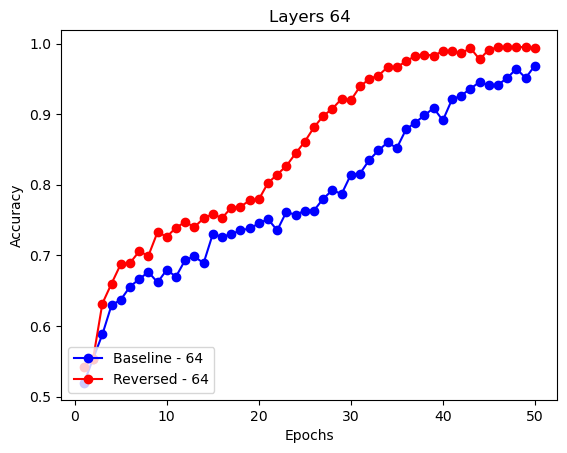

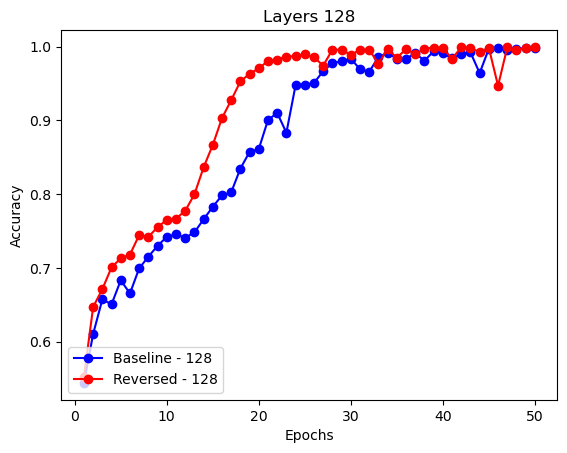

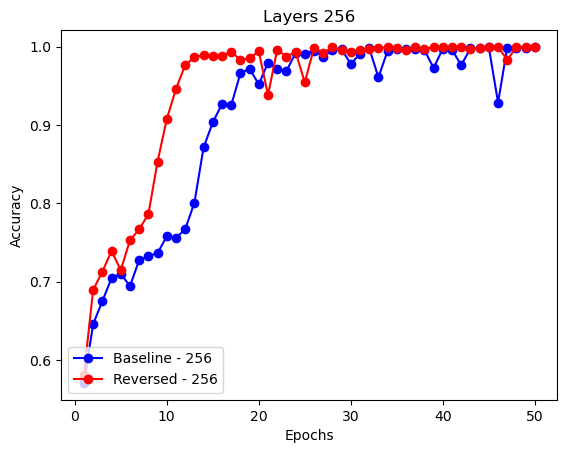

For 64 unit layers, baseline test accuracy: 96.88%, baseline test loss: 12.93%, reversed test accuracy: 99.16%, reversed test loss: 3.13%
For 128 unit layers, baseline test accuracy: 99.85%, baseline test loss: 1.16%, reversed test accuracy: 99.94%, reversed test loss: 0.35%
For 256 unit layers, baseline test accuracy: 99.92%, baseline test loss: 0.39%, reversed test accuracy: 99.97%, reversed test loss: 0.17%


In [47]:
for i, (baseline_acc, reversed_acc) in zip(value, zip(baseline_model_accuracy_array, reversed_model_accuracy_array)):
    epochs = range(1, len(baseline_model_accuracy) + 1)

    plt.plot(epochs, baseline_acc, 'bo-', label=f'Baseline - {i}')
    plt.plot(epochs, reversed_acc, 'ro-', label=f'Reversed - {i}')
    plt.legend(loc="lower left")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Layers {i}')
    plt.show()

# Print test accuracy and loss
for i, (baseline_test, reversed_test) in zip(value, zip(baseline_model_test_array, reversed_model_test_array)):
    print(f'For {i} unit layers, baseline test accuracy: {baseline_test[1]*100:.2f}%, baseline test loss: {baseline_test[0]*100:.2f}%, reversed test accuracy: {reversed_test[1]*100:.2f}%, reversed test loss: {reversed_test[0]*100:.2f}%')

In [37]:
# For 32 units, baseline test accuracy: 75%, reversed test accuracy: 86%, reversed test loss: 39%
# For 64 units, baseline test accuracy: 93%, reversed test accuracy: 99%, reversed test loss: 3%
# For 128 units, baseline test accuracy: 100%, reversed test accuracy: 99%, reversed test loss: 3%
# For 256 units, baseline test accuracy: 100%, reversed test accuracy: 100%, reversed test loss: 0%
# For 512 units, baseline test accuracy: 100%, reversed test accuracy: 85%, reversed test loss: 54%

In [48]:
for i, (baseline_test, reversed_test) in zip(value, zip(baseline_model_test_array, reversed_model_test_array)):
    if i == 256:
        print(f'The Best results is {i} unit layers, baseline test accuracy: {baseline_test[1]*100:.2f}%, baseline test loss: {baseline_test[0]*100:.2f}%, reversed test accuracy: {reversed_test[1]*100:.2f}%, reversed test loss: {reversed_test[0]*100:.2f}%')

The Best results is 256 unit layers, baseline test accuracy: 99.92%, baseline test loss: 0.39%, reversed test accuracy: 99.97%, reversed test loss: 0.17%
